In [24]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras.preprocessing import image_dataset_from_directory
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils import class_weight

### Parameters
- num_classes = 7: Specifies the number of emotion classes (e.g., Angry, Disgust, Fear, Happy, Sad, Surprise, Neutral).
- batch_size = 68: Defines the number of samples processed together in one training step.
- input_shape = (96, 96, 3): Sets the input image dimensions (96x96 pixels with 3 color channels for RGB).
- epochs_initial = 30: Number of epochs for the initial training phase.
- epochs_finetune = 20: Number of epochs for the fine-tuning phase.

### Loading Datasets
- image_dataset_from_directory: Loads images from directories for training, validation, and testing.
os.path.join("kuvat/emotions/train"): Path to the training dataset.

### Data Augmentation
- data_augmentation: A sequential pipeline of transformations to artificially increase the diversity of the training data.

In [25]:
# Parameters
num_classes = 7
batch_size = 68
input_shape = (96, 96, 3)
epochs_initial = 20
epochs_finetune = 15

# Load datasets
train_dataset = image_dataset_from_directory(
    os.path.join("kuvat/emotions/train"),
    image_size=input_shape[:2],
    batch_size=batch_size
)
validation_dataset = image_dataset_from_directory(
    os.path.join("kuvat/emotions/val"),
    image_size=input_shape[:2],
    batch_size=batch_size
)
test_dataset = image_dataset_from_directory(
    os.path.join("kuvat/emotions/test"),
    image_size=input_shape[:2],
    batch_size=batch_size
)

# Data Augmentation
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2)
])

normalization_layer = layers.Rescaling(1./255)

train_dataset = train_dataset.map(lambda x, y: (normalization_layer(data_augmentation(x, training=True)), y))
validation_dataset = validation_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))


Found 2445 files belonging to 7 classes.
Found 322 files belonging to 7 classes.
Found 314 files belonging to 7 classes.


KeyboardInterrupt: 

### Compute Class Weights:

- class_weight.compute_class_weight: Calculates weights for each class to balance the dataset. The 'balanced' mode ensures that classes with fewer samples are given higher weights.
-  when testing the model predicted happiness well but suprise and disgust were not predicted well. This is likely due to the imbalance in the dataset, where some classes have significantly more samples than others.

In [9]:
# Compute class weights
y_train = []
for _, labels in train_dataset:
    y_train.append(labels.numpy())
y_train = np.concatenate(y_train, axis=0)

class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))


This code builds a deep learning model using the MobileNetV2 architecture as a feature extractor to classify images into emotion categories. MobileNetV2 is used here to compare its performance against a custom CNN model to determine which works better for the task.

### MobileNetV2 as the Base Model:

- keras.applications.MobileNetV2: Loads the MobileNetV2 architecture pretrained on the ImageNet dataset.
- input_shape=input_shape: Specifies the input image dimensions (e.g., (96, 96, 3)).
- include_top=False: Excludes the fully connected layers at the top of the model, allowing customization for the specific task.
- weights='imagenet': Uses pretrained weights from ImageNet to leverage transfer learning.
- pooling='avg': Applies global average pooling to reduce the spatial dimensions of the feature maps.
- conv_base.trainable = False: Freezes the MobileNetV2 layers initially to retain the pretrained features.

In [10]:
# Build Model
conv_base = keras.applications.MobileNetV2(
    input_shape=input_shape,
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
conv_base.trainable = False  # Freeze at first

inputs = keras.Input(shape=input_shape)
x = conv_base(inputs)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True, monitor="val_loss"),
    ModelCheckpoint(filepath="emotions_MobileNetv2.keras", save_best_only=True, monitor="val_loss")
]

In [11]:
# Initial Training (only dense layers)
start_time = time.time()

history_initial = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs_initial,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=0
)

training_time_initial = time.time() - start_time


In [12]:
# Fine-tuning: Unfreeze top layers
conv_base.trainable = True

for layer in conv_base.layers[:-15]:
    layer.trainable = False  # Freeze most layers, fine-tune last ~30

# Re-compile with a small learning rate
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(1e-5),
    metrics=["accuracy"]
)


In [13]:
# Fine-tuning Training
start_time = time.time()

history_finetune = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs_finetune,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)

training_time_finetune = time.time() - start_time

# Evaluate model
test_loss, test_acc = model.evaluate(test_dataset)

print(f"Test Accuracy after fine-tuning: {test_acc:.3f}")

# Save results
np.savez("emotions_MobileNet.npz",
         test_acc=test_acc,
         test_loss=test_loss,
         training_time=training_time_initial + training_time_finetune,
         history_initial=history_initial.history,
         history_finetune=history_finetune.history)


Epoch 1/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 15s 268ms/step - accuracy: 0.2885 - loss: 2.7140 - val_accuracy: 0.3882 - val_loss: 1.5481
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 244ms/step - accuracy: 0.2969 - loss: 2.6022 - val_accuracy: 0.3882 - val_loss: 1.5494
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 239ms/step - accuracy: 0.3313 - loss: 2.4279 - val_accuracy: 0.3882 - val_loss: 1.5496
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 244ms/step - accuracy: 0.3188 - loss: 2.3631 - val_accuracy: 0.3882 - val_loss: 1.5510
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 225ms/step - accuracy: 0.3207 - loss: 2.0975 - val_accuracy: 0.3851 - val_loss: 1.5531
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 242ms/step - accuracy: 0.3262 - loss: 2.2026 - val_accuracy: 0.3882 - val_loss: 1.5520
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 239ms/step - accuracy: 0.3370 - loss: 2.1901 - val_accuracy: 0.3851 - val_loss: 1.5516
Epoch 8/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 243ms/step - accuracy: 0.3240 - loss: 2.1695 - val_accuracy: 

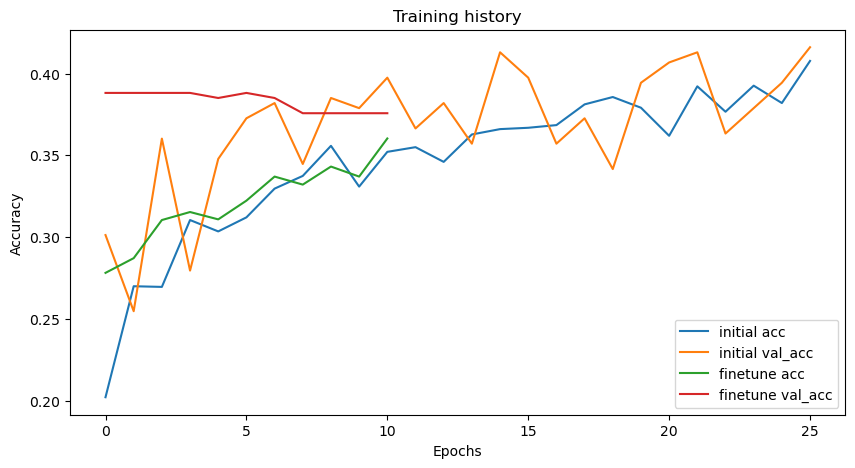

In [14]:
# Plot training history
def plot_history(histories, title="Training history"):
    plt.figure(figsize=(10, 5))

    for name, history in histories.items():
        plt.plot(history['accuracy'], label=f'{name} acc')
        plt.plot(history['val_accuracy'], label=f'{name} val_acc')

    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


plot_history({"initial": history_initial.history, "finetune": history_finetune.history})

The finetuning does not seem to improve the accuracy of the model. This could be due to several reasons, such as:
- The model may have already learned most of the relevant features during the initial training phase.
- The learning rate during finetuning might be too low, preventing the model from making significant updates to the weights.

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 174ms/step


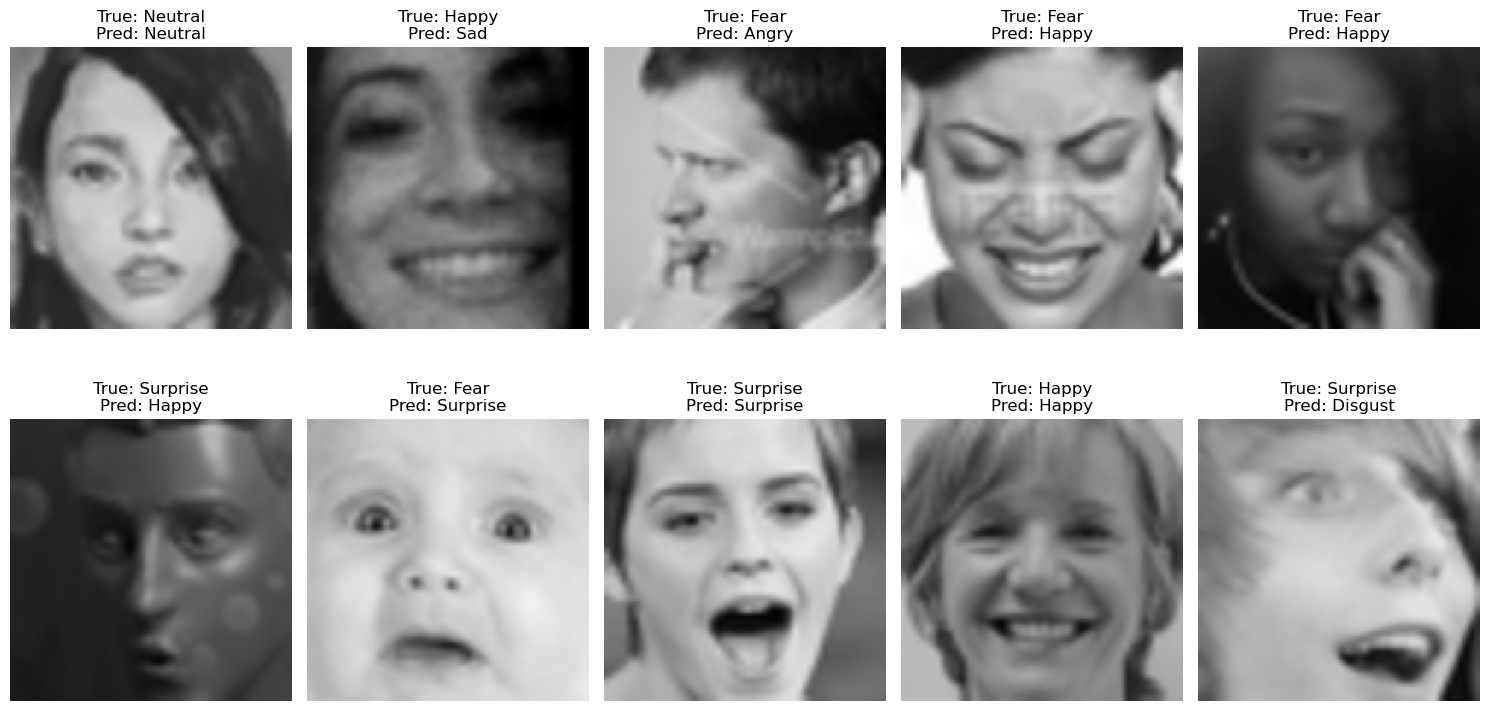

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Get a few test images and their true labels
x_test = []
y_test = []

for images, labels in test_dataset:
    x_test.append(images.numpy())
    y_test.append(labels.numpy())

x_test = np.concatenate(x_test, axis=0)
y_test = np.concatenate(y_test, axis=0)

# Make predictions
y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Define emotion labels
class_names = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

# Visualize a few test images with true and predicted labels
def visualize_predictions(start=0, num_images=10):
    plt.figure(figsize=(15, 8))

    for i in range(num_images):
        plt.subplot(2, 5, i+1)  # 2 rows, 5 images per row
        img = x_test[start + i]
        img = np.clip(img, 0.0, 1.0)  # Ensure values are between 0 and 1
        plt.imshow(img)  # Display the image
        plt.axis('off')

        true_label = class_names[y_test[start + i]]  # True label
        pred_label = class_names[y_pred_labels[start + i]]  # Predicted label

        plt.title(f"True: {true_label}\nPred: {pred_label}")

    plt.tight_layout()
    plt.show()

# Visualize first 10 images from the test set
visualize_predictions(start=0, num_images=10)


In [22]:
# Calculate class-wise accuracies
class_accuracies = {}
for i, class_name in enumerate(class_names):
    true_class_indices = (y_test == i)
    correct_predictions = (y_pred_labels[true_class_indices] == i).sum()
    total_samples = true_class_indices.sum()
    class_accuracies[class_name] = correct_predictions / total_samples

# Display class-wise accuracies
for class_name, accuracy in class_accuracies.items():
    print(f"Accuracy for class '{class_name}': {accuracy:.2%}")


Accuracy for class 'Angry': 14.29%
Accuracy for class 'Disgust': 20.00%
Accuracy for class 'Fear': 14.29%
Accuracy for class 'Happy': 68.67%
Accuracy for class 'Sad': 29.63%
Accuracy for class 'Surprise': 64.71%
Accuracy for class 'Neutral': 44.26%


In [23]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and F1 score for each class
class_f1_scores = {}
for i, class_name in enumerate(class_names):
    true_class_indices = (y_test == i)
    pred_class_indices = (y_pred_labels == i)

    precision = precision_score(y_test, y_pred_labels, labels=[i], average='macro', zero_division=0)
    recall = recall_score(y_test, y_pred_labels, labels=[i], average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred_labels, labels=[i], average='macro', zero_division=0)

    class_f1_scores[class_name] = {
        "precision": precision,
        "recall": recall,
        "f1_score": f1
    }

# Print header
print(f"{'Class':<10} {'Precision':<10} {'Recall':<10} {'F1 Score':<10}")
print("-" * 40)

# Each class's scores
for class_name, scores in class_f1_scores.items():
    print(f"{class_name:<10} {scores['precision']:<10.2f} {scores['recall']:<10.2f} {scores['f1_score']:<10.2f}")

Class      Precision  Recall     F1 Score  
----------------------------------------
Angry      0.24       0.14       0.18      
Disgust    0.10       0.20       0.13      
Fear       0.33       0.14       0.20      
Happy      0.53       0.69       0.60      
Sad        0.52       0.30       0.38      
Surprise   0.43       0.65       0.52      
Neutral    0.36       0.44       0.39      


In [19]:
import os
from PIL import Image

# Output folder
output_dir = "test_predictions_images"
os.makedirs(output_dir, exist_ok=True)

# Save the first N images with predictions
num_images_to_save = 10

group_by = "pred"  # or "true"
base_dir = "predictions_by_class"

for i in range(num_images_to_save):
    img = (x_test[i] * 255).astype(np.uint8)
    img_pil = Image.fromarray(img)

    label = class_names[y_pred_labels[i]] if group_by == "pred" else class_names[y_test[i]]
    subdir = os.path.join(base_dir, label)
    os.makedirs(subdir, exist_ok=True)

    filename = f"{i:03d}_true-{class_names[y_test[i]]}_pred-{class_names[y_pred_labels[i]]}.png"
    img_pil.save(os.path.join(subdir, filename))

# Save test images, true labels, predicted probabilities, and predicted labels
np.savez("test_results2.npz",
         x_test=x_test,
         y_test=y_test,
         y_pred=y_pred,
         y_pred_labels=y_pred_labels,
         class_names=class_names)



In [20]:
import json

# Save class F1 scores to a JSON file
f1_scores_file = "class_f1_scores2.json"
with open(f1_scores_file, "w") as file:
    json.dump(class_f1_scores, file, indent=4)

print(f"Class F1 scores saved to {f1_scores_file}")

Class F1 scores saved to class_f1_scores2.json
